In this notebook, we will learn the theory and implementation of the Grad-CAM method.  

### Imports

In [ ]:
# %tensorflow_version 2.x

import warnings
warnings.filterwarnings("ignore")

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub

### Building Our Visualization Model
First, we will load the VGG16_modified (transfer learning) model, which has been adjusted to the cats_vs_dog dataset. Then, we will create a visualization model which has two outputs:

1. Intermediate activation maps (Conv2D outputs) of the VGG16_modified.


2. VGG16_modified output, which is a Tensor having 2 probabilities. In the next section, we will see how Grad-CAM smartly takes deriviation from this output w.r.t to the intermediate activation maps.

In [ ]:
base_model = tf.keras.models.load_model("VGG16_transfer_learning.h5", compile=False)
base_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,0

 Total params: 14,717,762 (56.14 MB)

 Trainable params: 7,081,474 (27.01 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [ ]:
num_of_layers_transfer_learning = 4
vis_outputs = [layer.output for layer in base_model.layers[1:-num_of_layers_transfer_learning]]
# Define the visulization_model
vis_model = Model([base_model.input], [vis_outputs, base_model.output])

In [ ]:
for i in range(len(vis_model.layers)):
  print(f"Layer index {i}:\t\t {vis_model.layers[i].name}")

Layer index 0:		 input_layer_1
Layer index 1:		 block1_conv1
Layer index 2:		 block1_conv2
Layer index 3:		 block1_pool
Layer index 4:		 block2_conv1
Layer index 5:		 block2_conv2
Layer index 6:		 block2_pool
Layer index 7:		 block3_conv1
Layer index 8:		 block3_conv2
Layer index 9:		 block3_conv3
Layer index 10:		 block3_pool
Layer index 11:		 block4_conv1
Layer index 12:		 block4_conv2
Layer index 13:		 block4_conv3
Layer index 14:		 block4_pool
Layer index 15:		 block5_conv1
Layer index 16:		 block5_conv2
Layer index 17:		 block5_conv3
Layer index 18:		 block5_pool
Layer index 19:		 global_average_pooling2d
Layer index 20:		 batch_normalization
Layer index 21:		 dense


As we can see, layer index 17 is the last convolutional layer, which we will use for interpretability purposes.

### Implementing Grad-CAM

The get_CAM function below implements the theory of Grad-CAM method explained in [this paper](https://arxiv.org/pdf/1610.02391). Let's delve into the code step by step:

1. First, we get the output of the visualization model defined earlier. The model takes an input image and gives its predicted label along with the activation maps.

2. We select the activation map we want, by specifying the layer_index amount. In this example, we have chosen the last activation map belonging to the last Conv2D layer (index 17).

3. In this stage, we calculate the weights of each feature in the activation map, which impact the classification result. In other words, the features (filters) with higher weights are more decisive in the network's prediciton.

$$\alpha_k^c = \frac{1}{Z} \Sigma_i \Sigma_j \frac{\partial y^c}{\partial A_{ij}^k}$$

In the above formula, we took gradient from the model's output ($y^c$) w.r.t. activation maps ($A_{ij}^k$). Afterwards, we took GlobalAveragePooling (as mentioned in the paper). Note that $Z = i.j$

4. After calculating the weights, we mulitply each weight with its corresponding feature to acheive the heatmap.

$$L^c_{Grad-CAM} = ReLU(\Sigma_k \; \alpha_k^c \; A^k)$$

Please note that in the above formula, we took a sum over and remove the last dimension to obtain a 2D ndarray. In addition, the ReLU is used beacause negative values for pixels are undefined.

In [ ]:
def get_CAM(processed_image, actual_label, layer_index = 16):

    # One custom training epoch and getting the loss
    with tf.GradientTape() as tape:
        activation_maps, predictions = vis_model(processed_image)
        last_activation_map = activation_maps[layer_index]
        predictions = predictions[0]
        print(predictions)
        # print("Selected activation map:\t{}".format(len(last_activation_map)))
        print("Selected activation map:\t{}".format(last_activation_map.shape))

        print("Pred values:\t\t{}\t{}".format(predictions[0].shape, predictions))

        # Note the variable which deriviation is based on
        tape.watch(last_activation_map)

        ## Use binary cross entropy loss
        ## actual_label is 0 if cat, 1 if dog
        pred_prob = predictions[:,1]
        # make sure actual_label is a float, like the rest of the loss calculation
        actual_label = tf.cast(actual_label, dtype=tf.float32)

        # add a tiny value to avoid log of 0
        smoothing = 0.00001

        # Calculate loss as binary cross entropy
        loss = tf.keras.losses.binary_crossentropy(y_true = actual_label, y_pred = pred_prob + smoothing)
        print(f"Binary loss: {loss}")

    # get the gradient of the loss with respect to the activation map
    print("Activation map and Loss shapes (deravitive):\t{}\t{}".format(last_activation_map.shape, loss.shape))
    weights = tape.gradient(loss, last_activation_map)
    print("Weights shape (before mean):\t{}".format(weights.shape))
    # Global Average Pooling on the weights
    weights = K.mean(weights, axis=(0,1,2))
    print("Weights shape (after Global Average):\t{}".format(weights.shape))

    last_activation_map = np.squeeze(last_activation_map.numpy())
    weights = weights.numpy()

    # Multiply the Activation map with the weights
    for i in range(512):
        last_activation_map[:,:,i] *= weights[i]

    # Now we should take mean over the last dimension (number of channels)
    print(f"Activation map before taking mean: {last_activation_map.shape}")
    heatmap = np.mean(last_activation_map, axis=-1)
    print(f"Activation map {last_activation_map.shape} mean on number of channels {heatmap.shape}")

    # ReLU activation function, as mentioned in the original paper
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()

    del activation_maps, weights, loss

    return heatmap

### Reload some test images

In [ ]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.CJH4GI_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
labels= {
    0: "CAT",
    1: "DOG"
}

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
print(f"Addition of two tuples sample:\t{IMAGE_SIZE + (3,)}")

# resizes the image and normalizes the pixel values
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

# Only test_batches_suffice
test_batches = test_examples.map(format_image).batch(1)

Addition of two tuples sample:	(224, 224, 3)


### Visualize Results

In [ ]:
def show_sample(sample_image, sample_label):

    print("Sample image shape:\t{}".format(sample_image.shape))

    _, pred = vis_model.predict(sample_image)
    pred = pred[0][0]

    pred_val = np.argmax(pred, axis=-1)
    pred_label = labels[pred_val]


    heatmap = get_CAM(sample_image, sample_label)
    sample_image = sample_image[0]
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    sample_img_numpy = sample_image.numpy()
    print("Imposing main image and heatmap on it:\t{}\t{}".format(sample_img_numpy.shape, heatmap.shape))
    super_imposed_image = cv2.addWeighted(sample_img_numpy, 0.8, heatmap.astype(np.float32), 0.2, 0.0)

    f,ax = plt.subplots(1, 3, figsize=(18, 6))
    # print(type(sample_label))
    # sample_label = sample_label.numpy()
    # pred_label = pred_label.numpy()

    ax[0].imshow(sample_image)
    ax[0].set_title(f"True label: {labels[int(sample_label.numpy())]} \n Predicted label: {pred_label}")
    ax[0].axis('off')

    ax[1].imshow(heatmap)
    ax[1].set_title("Gradient-Weighted CAM")
    ax[1].axis('off')

    ax[2].imshow(super_imposed_image)
    ax[2].set_title("Image and activation map superimposed")
    ax[2].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
sample_index = 29

for img, label in test_batches.take(sample_index):
    sample_image = img
    sample_label = label

Sample image shape:	(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
tf.Tensor([[0.6117416  0.38825837]], shape=(1, 2), dtype=float32)
Selected activation map:	(1, 14, 14, 512)
Pred values:		(2,)	[[0.6117416  0.38825837]]
Binary loss: 0.4914615750312805
Activation map and Loss shapes (deravitive):	(1, 14, 14, 512)	()
Weights shape (before mean):	(1, 14, 14, 512)
Weights shape (after Global Average):	(512,)
Activation map before taking mean: (14, 14, 512)
Activation map (14, 14, 512) mean on number of channels (14, 14)
Imposing main image and heatmap on it:	(224, 224, 3)	(224, 224, 3)


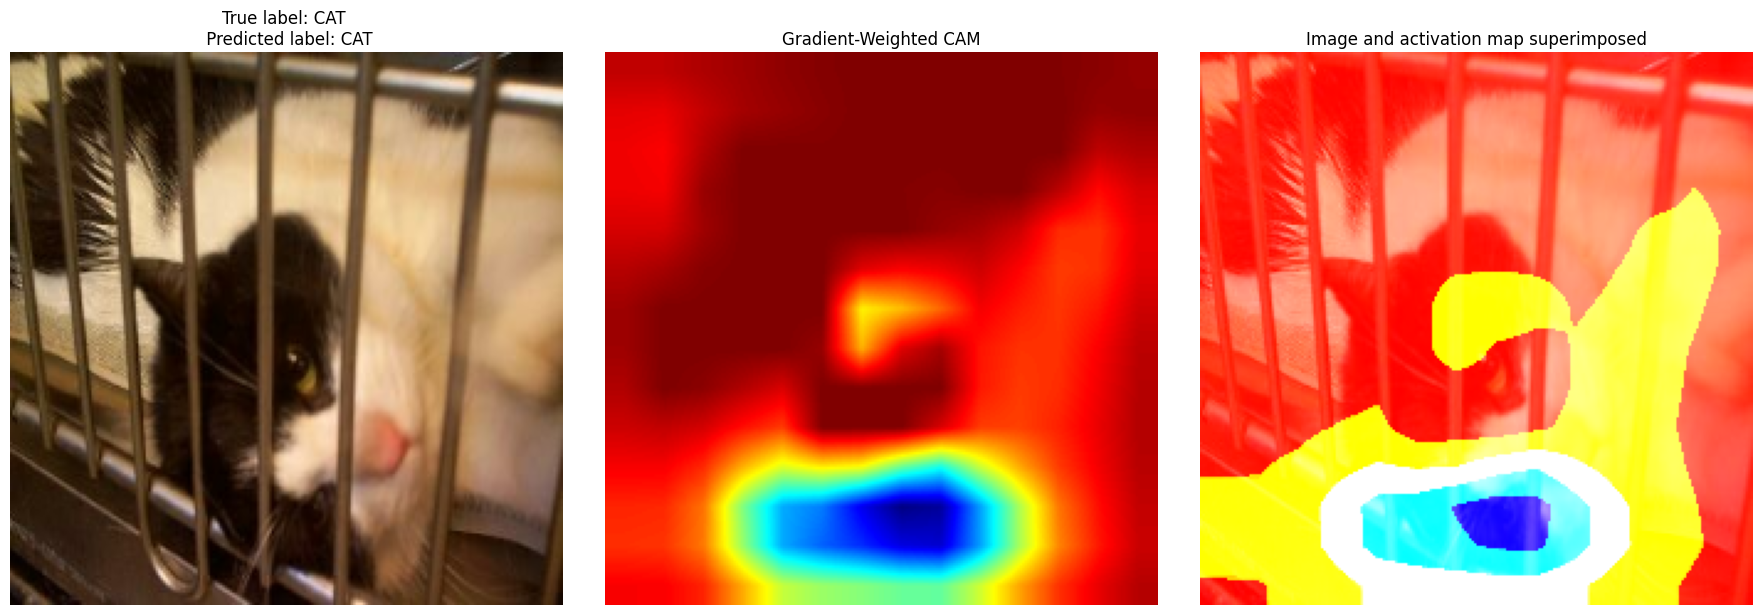

In [ ]:
show_sample(sample_image, sample_label)

As we can see, the parts related to the cat's face have the greatest gradient (weight).